In [2]:
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

In [3]:
dataframe=pd.read_csv('./mfcc_data.csv')
print(dataframe.shape)
dataframe.head()

(5252, 44)


,gender,emotion,actor,path,0,1,2,3,4,5,...,30,31,32,33,34,35,36,37,38,39
0,male,neutral,1,F:/ravdess_tess/Actor_01/03-01-01-01-01-01-01.wav,-700.398926,58.630211,-3.025852,16.040241,4.248529,3.869935,...,-1.411359,-2.769772,-2.042009,-2.522663,-2.507448,-2.250499,-0.381507,-2.481059,-2.791023,-2.244865
1,male,neutral,1,F:/ravdess_tess/Actor_01/03-01-01-01-01-02-01.wav,-695.557861,59.240154,-5.372777,19.776367,5.200387,3.324630,...,-1.055913,-3.102514,-1.697880,-2.922661,-2.544465,-1.289832,-0.797254,-3.586074,-2.706395,-2.812933
2,male,neutral,1,F:/ravdess_tess/Actor_01/03-01-01-01-02-01-01.wav,-694.004333,61.496510,-3.262743,16.971298,2.142968,4.266798,...,-1.382858,-2.590943,-1.929074,-2.390322,-2.269381,-2.486079,-0.589257,-3.248326,-2.979813,-2.769281
3,male,neutral,1,F:/ravdess_tess/Actor_01/03-01-01-01-02-02-01.wav,-687.513367,59.441540,-0.703714,16.645708,3.730826,6.181194,...,-2.024173,-2.586190,-2.420421,-3.243219,-2.762588,-1.960003,-0.453890,-2.976706,-2.914763,-3.909605
4,male,calm,1,F:/ravdess_tess/Actor_01/03-01-02-01-01-01-01.wav,-729.980164,66.515892,-0.941984,19.070974,4.297080,5.635082,...,-1.519869,-1.797158,-1.296814,-3.051891,-1.131349,-1.063672,-1.141021,-2.373389,-3.204345,-3.363193


label_encoder= LabelEncoder()
dataframe['emotion']= label_encoder.fit_transform(dataframe['emotion'])
dataframe['emotion'].unique()
dataframe.head(50)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(['path','emotion','gender','actor'],axis=1)
                                                    , dataframe['emotion']
                                                    , test_size=0.3
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[140:160]

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
52,-663.245117,56.914234,-4.322424,12.026352,0.839215,0.998284,-9.376346,-3.472342,-12.654016,-3.198260,...,-2.864697,-4.068131,-0.447791,-2.260700,-1.746792,-0.241587,0.889007,-0.387938,-1.452217,-2.122471
2417,-589.761597,37.559975,-26.368683,-5.077186,-25.508503,-16.069012,-12.667822,-12.859401,-17.119534,-1.359045,...,0.178495,4.127332,-0.702421,-6.219831,-4.409256,-1.872964,-0.486630,0.409506,4.464584,8.865886
411,-489.890076,27.889845,-20.990011,6.561702,-16.940233,-9.981713,-8.701595,-15.527115,-13.190081,-4.935193,...,0.215081,1.755683,-1.034058,-4.324247,0.139281,1.580326,0.438118,-1.096318,3.318619,7.434766
2413,-589.272339,48.332993,-28.435795,-2.738060,-26.718880,-16.096424,-15.026200,-13.370799,-17.589655,-2.007025,...,3.917078,2.663623,-2.458679,-7.460005,-3.427298,-1.993258,-1.583948,-1.156482,4.832943,7.698437
3326,-292.392334,31.338638,-35.858158,21.562761,-20.795460,4.944282,-13.481802,1.463832,-6.345480,5.433447,...,-0.534154,1.516690,-2.405283,-2.015558,-0.744112,1.310964,0.142277,-2.366256,-0.045133,2.067626
3075,-455.352417,74.130424,8.359039,37.115162,-13.340558,3.234139,-10.810410,-12.931018,-13.969462,-4.033225,...,2.236881,6.450092,6.814971,5.916813,6.941803,6.358749,6.242890,2.598115,3.457117,2.627498
3494,-400.154266,68.406006,24.687536,43.886578,-1.777203,10.960110,-10.714781,-3.272096,-8.762752,-0.606936,...,-1.381485,8.972528,5.971830,7.386127,3.123388,3.532395,4.568897,7.295309,9.006443,5.371990
2842,-439.939514,60.708702,-2.753253,37.431927,-11.094934,4.901221,-12.578640,-6.721243,-11.341740,1.506621,...,5.372310,5.109254,2.507212,0.867501,4.742884,1.547794,4.827111,4.032698,3.558613,2.714841
1844,-593.280762,61.627655,3.040722,17.175785,-5.373684,10.994773,-8.568574,-1.740356,-10.992760,3.354027,...,2.469854,0.580994,2.174014,1.737645,2.477542,2.609453,-0.596339,-1.129402,-0.016730,2.864747
1479,-626.912781,81.775078,-4.297923,20.895699,11.046813,5.094439,-0.525650,1.836784,-6.179443,5.827449,...,1.830520,2.167081,0.958481,0.954688,-1.356724,0.002765,-0.710360,-0.602619,-1.950351,-1.861999


In [5]:
y_train.value_counts()

fear        551
angry       545
happy       534
sad         533
surprise    424
disgust     415
neutral     411
calm        263
Name: emotion, dtype: int64

In [6]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
3992,0.620348,1.429633,0.902116,-0.258695,0.826235,-0.098448,-0.944982,1.295247,-1.534813,0.010823,...,-0.585940,-1.133458,-0.421854,-0.462575,0.006447,0.151085,0.719931,0.937916,1.564189,1.116593
3942,0.217969,1.789998,2.017981,-0.359569,-0.565307,-1.322534,-0.359769,1.198246,-1.504280,1.161064,...,0.142399,0.284493,1.471809,1.005075,1.628698,1.185277,1.443630,0.791217,0.314278,-0.175237
2751,1.266544,-0.236147,-0.994866,-0.748304,-2.327632,0.260023,0.123062,-0.201765,-0.822560,1.637019,...,0.514240,0.905093,-0.018114,0.504307,0.097492,0.172124,0.318137,0.059210,0.087323,-0.116798
4092,0.274949,1.408209,1.683918,-1.046155,-0.780828,-0.796001,-0.377063,2.192986,-0.868405,1.660470,...,0.532461,0.628798,0.834033,0.188838,0.591369,-0.106399,0.431452,0.185472,1.330102,0.617407
564,-1.810111,0.260210,-0.426990,-0.172734,-0.361728,-0.484847,-1.417407,-0.178203,0.205248,0.043218,...,1.130341,1.464299,0.734969,0.644988,-0.230767,-0.420789,-0.546405,-0.123099,-0.325182,-0.629709


In [7]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
#pickle.dump(lb,outfile)
outfile.close()

(3676, 40)
['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]]


In [8]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(3676, 40, 1)

In [9]:

model = Sequential()
model.add(Conv1D(32, 5, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Dropout(0.2))
model.add(Conv1D(32, 5, padding='same'))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Conv1D(64, 5, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Conv1D(64, 5, padding='same'))
model.add(Flatten())

model.add(Dense(8)) # Target class number
model.add(Activation('softmax'))


#opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()
#loss: 0.6894 - accuracy: 0.7454 - val_loss: 0.6964 - val_accuracy: 0.7506
#better but less acc


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 40, 32)            192       
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 32)            128       
_________________________________________________________________
activation_1 (Activation)    (None, 40, 32)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 32)             5152      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 32)           

In [10]:
model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=40, validation_data=(X_test, y_test))


Train on 3676 samples, validate on 1576 samples
Epoch 1/40
3676/3676 [==============================] - 2s 642us/step - loss: 1.5675 - accuracy: 0.4459 - val_loss: 1.3884 - val_accuracy: 0.5615
Epoch 2/40
3676/3676 [==============================] - 1s 391us/step - loss: 1.1638 - accuracy: 0.5830 - val_loss: 1.0000 - val_accuracy: 0.6332
Epoch 3/40
3676/3676 [==============================] - 2s 425us/step - loss: 1.0580 - accuracy: 0.6145 - val_loss: 0.8870 - val_accuracy: 0.6574
Epoch 4/40
3676/3676 [==============================] - 1s 373us/step - loss: 0.9806 - accuracy: 0.6363 - val_loss: 0.8638 - val_accuracy: 0.6758
Epoch 5/40
3676/3676 [==============================] - 1s 386us/step - loss: 0.9343 - accuracy: 0.6572 - val_loss: 0.8333 - val_accuracy: 0.6853
Epoch 6/40
3676/3676 [==============================] - 1s 400us/step - loss: 0.8930 - accuracy: 0.6678 - val_loss: 0.8347 - val_accuracy: 0.6796
Epoch 7/40
3676/3676 [==============================] - 1s 391us/step - los

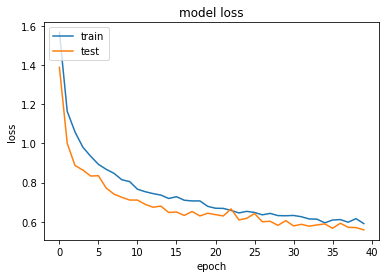

In [11]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

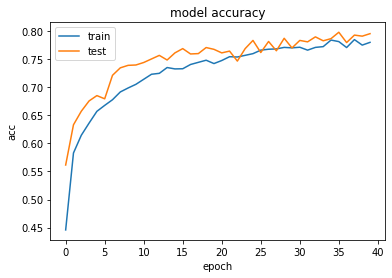

In [12]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [13]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1576/1576 [==============================] - 0s 85us/step
Loss of the model is -  0.5580386135178774
1576/1576 [==============================] - 0s 88us/step
Accuracy of the model is -  79.56852912902832 %


In [14]:
# PREDICTIONS
pred = model.predict(X_test)
pred=pred.argmax(axis=1)
pred = pred.astype(int).flatten()
pred = (lb.inverse_transform((pred)))
pred = pd.DataFrame({'Predicted Values': pred})

# ACTUAL LABELS
y=y_test.argmax(axis=1)
y = y.astype(int).flatten()
y= (lb.inverse_transform((y)))
y = pd.DataFrame({'Actual Values': y})

# COMBINE BOTH 
finaldf = y.join(pred)
finaldf[140:150]

,Actual Values,Predicted Values
140,neutral,neutral
141,fear,angry
142,sad,fear
143,angry,angry
144,surprise,surprise
145,angry,angry
146,fear,fear
147,calm,calm
148,calm,calm
149,happy,fear


In [15]:
print(classification_report(y, pred, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.86      0.77      0.82       231
        calm       0.62      0.78      0.69       113
     disgust       0.75      0.80      0.77       177
        fear       0.78      0.82      0.80       225
       happy       0.86      0.72      0.78       242
     neutral       0.92      0.84      0.88       177
         sad       0.75      0.79      0.77       243
    surprise       0.80      0.88      0.84       168

    accuracy                           0.80      1576
   macro avg       0.79      0.80      0.79      1576
weighted avg       0.80      0.80      0.80      1576



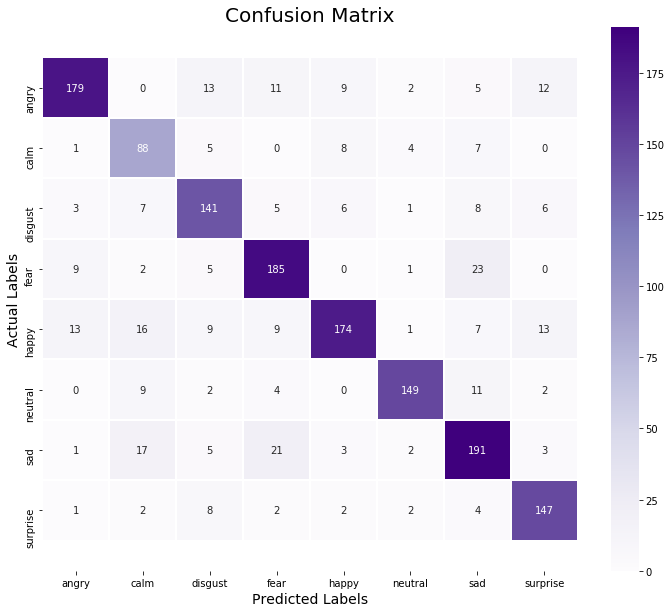

In [16]:
cm = confusion_matrix(y, pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

In [17]:
# Save model and weights
model_name = 'Audio_Emotion_Model_2ds.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at C:\Users\SCS\FYP2\saved_models\Audio_Emotion_Model_2ds.h5 


In [18]:
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Audio_Emotion_Model_2ds.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 79.57%


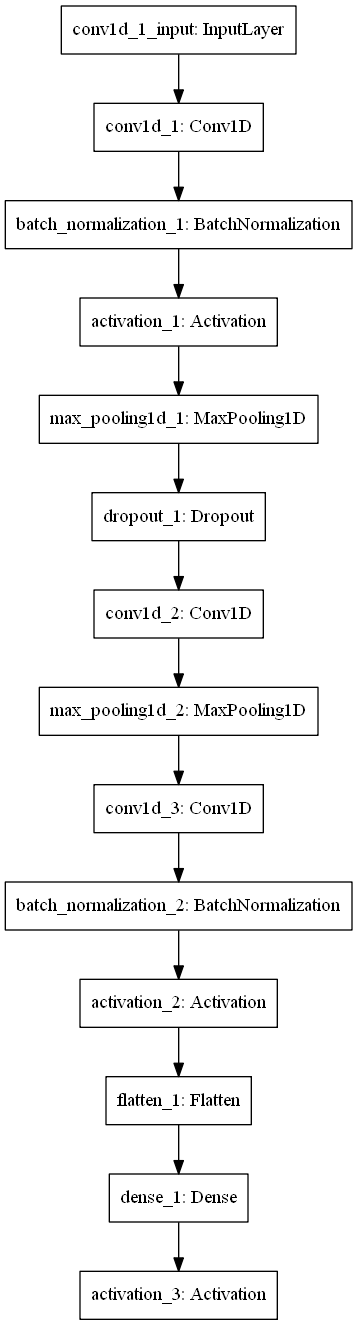

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(model)